## Intuition for Conformal Prediction Intervals by Rajiv Shah

This notebook, [bit.ly/raj_conf](https://bit.ly/raj_conf),  walks through computing a very simple prediction interval using conformal predictions. This is intended as a toy example to learn how this works.  Typical applications will use a more sophisticated methodology along with existing implementations found within the resources below.

A very quick overview is found on [Tik Tok](https://www.tiktok.com/@rajistics/video/7145960334270975275?is_from_webapp=1&sender_device=pc&web_id=7106277315414181422) or a longer walkthrough of the notebook is on [Youtube](https://youtu.be/ZUK4zR0IeLU).

#### Resources:

Quick intro to conformal prediction in [medium](https://towardsdatascience.com/mapie-explained-exactly-how-you-wished-someone-explained-to-you-78fb8ce81ff3)

A Gentle Introduction to Conformal Prediction and
Distribution-Free Uncertainty Quantification, [paper link](https://people.eecs.berkeley.edu/~angelopoulos/publications/downloads/gentle_intro_conformal_dfuq.pdf)

[Awesome Conformal Prediction](https://github.com/valeman/awesome-conformal-prediction) (lots of resources)


In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

#### Get California housing dataset, and split it in 3 sets

Train, calibration, and test set

In [ ]:
X, y = fetch_california_housing(return_X_y=True, as_frame=True)
X_train_and_cal, X_test, y_train_and_cal, y_test = train_test_split(X, y, test_size=0.02,random_state=11)
X_train, X_cal, y_train, y_cal = train_test_split(
  X_train_and_cal, y_train_and_cal, test_size=0.01,random_state=11)

In [ ]:
print (X_train.shape)
print (X_cal.shape)
print (X_test.shape)

(20024, 8)
(203, 8)
(413, 8)


#### 1. Fit model on training data

In [ ]:
random.seed(1234)
model = RandomForestRegressor().fit(X_train, y_train)

#### 2. Make prediction on calibration data used to identify the prediction interval

In [ ]:
y_cal_pred = model.predict(X_cal)

#### 3. Examine Prediction Errors

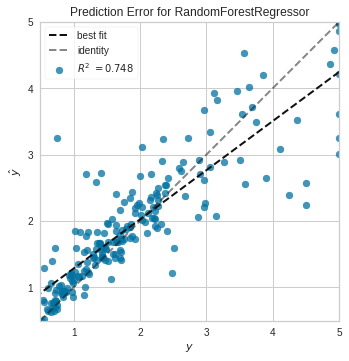

In [ ]:
from yellowbrick.regressor import PredictionError
visualizer = PredictionError(model)
visualizer.score(X_cal, y_cal)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

Compute absolute errors made by the model on calibration data

In [ ]:
y_cal_error = np.abs(y_cal - y_cal_pred)

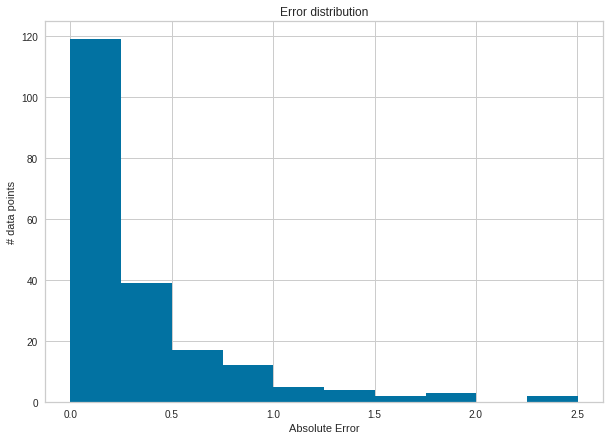

In [ ]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(y_cal_error)
plt.xlabel("Absolute Error")
plt.ylabel("# data points")
plt.title("Error distribution")
# Show plot
plt.show()

#### 4. Get 1-alpha quantile from the distribution of absolute errors

In [ ]:
quantile = y_cal_error.quantile(q=.95, interpolation='higher')
quantile

1.2559399999999994

Let's visualize this on the histogram

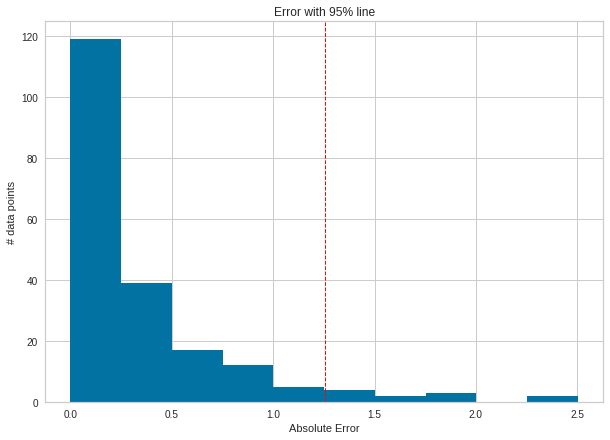

In [ ]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(y_cal_error)
plt.axvline(quantile, color='red', linestyle='dashed', linewidth=1)
plt.xlabel("Absolute Error")
plt.ylabel("# data points")
plt.title("Error with 95% line")
# Show plot

# Show plot
plt.show()

#### 5. Make prediction on test data

In [ ]:
y_test_pred = model.predict(X_test)

#### 6. Compute intervals by either subtracting or adding the quantile to the predictions

In [ ]:
y_test_interval_pred_left = y_test_pred - quantile
y_test_interval_pred_right = y_test_pred + quantile

In [ ]:
df = pd.DataFrame(list(zip(y_test,y_test_pred,y_test_interval_pred_left,y_test_interval_pred_right)),
                  columns=['actual','predicted','lower_interval','upper_interval'])
df


,actual,predicted,lower_interval,upper_interval
0,0.762,0.776470,-0.479470,2.03241
1,1.732,2.147140,0.891200,3.40308
2,1.125,2.504181,1.248241,3.76012
3,1.370,1.882770,0.626830,3.13871
4,1.856,2.201380,0.945440,3.45732
...,...,...,...,...
408,1.073,1.196300,-0.059640,2.45224
409,0.517,0.944360,-0.311580,2.20030
410,2.316,1.809710,0.553770,3.06565
411,0.738,0.947840,-0.308100,2.20378


In [ ]:
df1 = df.sample(n=8, replace=True, random_state=15)

Plot a few intervals

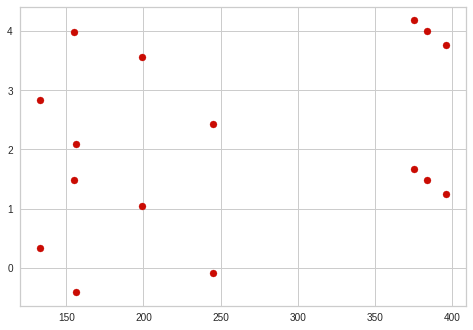

In [ ]:

plt.scatter(x=df1.index,y=df1['lower_interval'], color = 'r')
plt.scatter(x=df1.index,y=df1['upper_interval'], color = 'r')
plt.show()

Adding the actual values

See one example on the far right, where the actual was outside of the prediction interval

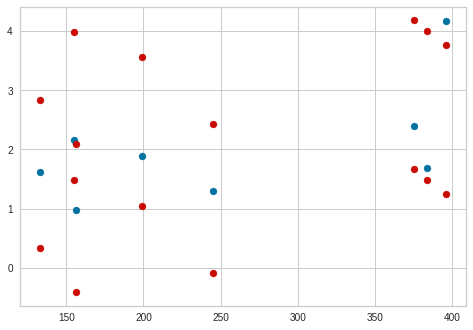

In [ ]:
plt.scatter(x=df1.index, y= df1['actual'])
plt.scatter(x=df1.index,y=df1['lower_interval'], color = 'r')
plt.scatter(x=df1.index,y=df1['upper_interval'], color = 'r')
plt.show()